# **Integrated HVAC-Battery Simulation: A Python-Based Approach Using TESPy and PyBaMM**



##  **Objective** : To simulate the dynamic interaction between an automotive HVAC system (modeled using TESPy) and a  battery pack (modeled using PyBaMM), evaluating how real-time compressor power demand affects cabin temperature regulation (maintained at 25°C) and battery performance over time — including State of Charge (SoC) and OCV drop

### **Library Import** 


In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from tespy.networks import Network
from tespy.components import CycleCloser, SimpleHeatExchanger, Valve, Compressor
from tespy.connections import Connection

### Important library used are
 #### 1)Tespy is used for static Thermodynamics modelling and simulations 
 #### 2)pybamm is used for Battery dynamics 


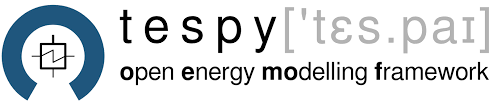
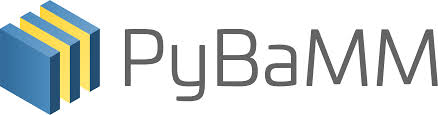

## **Modeling Simple Hvac System**

In [2]:
# 1. Create Network 
hvac = Network(T_unit='C', p_unit='bar', h_unit='kJ / kg')
fluid = {'R134a': 1}

# 2. Components
cc = CycleCloser('cycle closer')
evap = SimpleHeatExchanger('evaporator')
comp = Compressor('compressor')
cond = SimpleHeatExchanger('condenser')
valve = Valve('expansion valve')

# 3. Establish Connections 
c1 = Connection(cc, 'out1', evap, 'in1', label='1')
c2 = Connection(evap, 'out1', comp, 'in1', label='2')
c3 = Connection(comp, 'out1', cond, 'in1', label='3')
c4 = Connection(cond, 'out1', valve, 'in1', label='4')
c0 = Connection(valve, 'out1', cc, 'in1', label='0')

hvac.add_conns(c1, c2, c3, c4, c0)

# 4. Component Parameters 
evap.set_attr(pr=0.97)
cond.set_attr(pr=0.95)
comp.set_attr(eta_s=0.7)

# 5. Initial Conditions 
c1.set_attr(m=0.02, fluid=fluid)
c2.set_attr(x=1, T=5)
c4.set_attr(x=0, T=45)

# 6. Design Solve 
hvac.solve('design')
hvac.save('hvac_design')


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.18e+06   | 0 %        | 0.00e+00   | 1.15e+06   | 4.38e+05   | 0.00e+00   | 0.00e+00   
 2     | 9.21e+04   | 11 %       | 0.00e+00   | 2.45e-10   | 1.32e+05   | 0.00e+00   | 0.00e+00   
 3     | 2.34e-10   | 100 %      | 0.00e+00   | 2.45e-10   | 2.00e-11   | 0.00e+00   | 0.00e+00   
 4     | 2.34e-10   | 100 %      | 0.00e+00   | 2.45e-10   | 2.00e-11   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.01 s, Iterations per second: 361.38


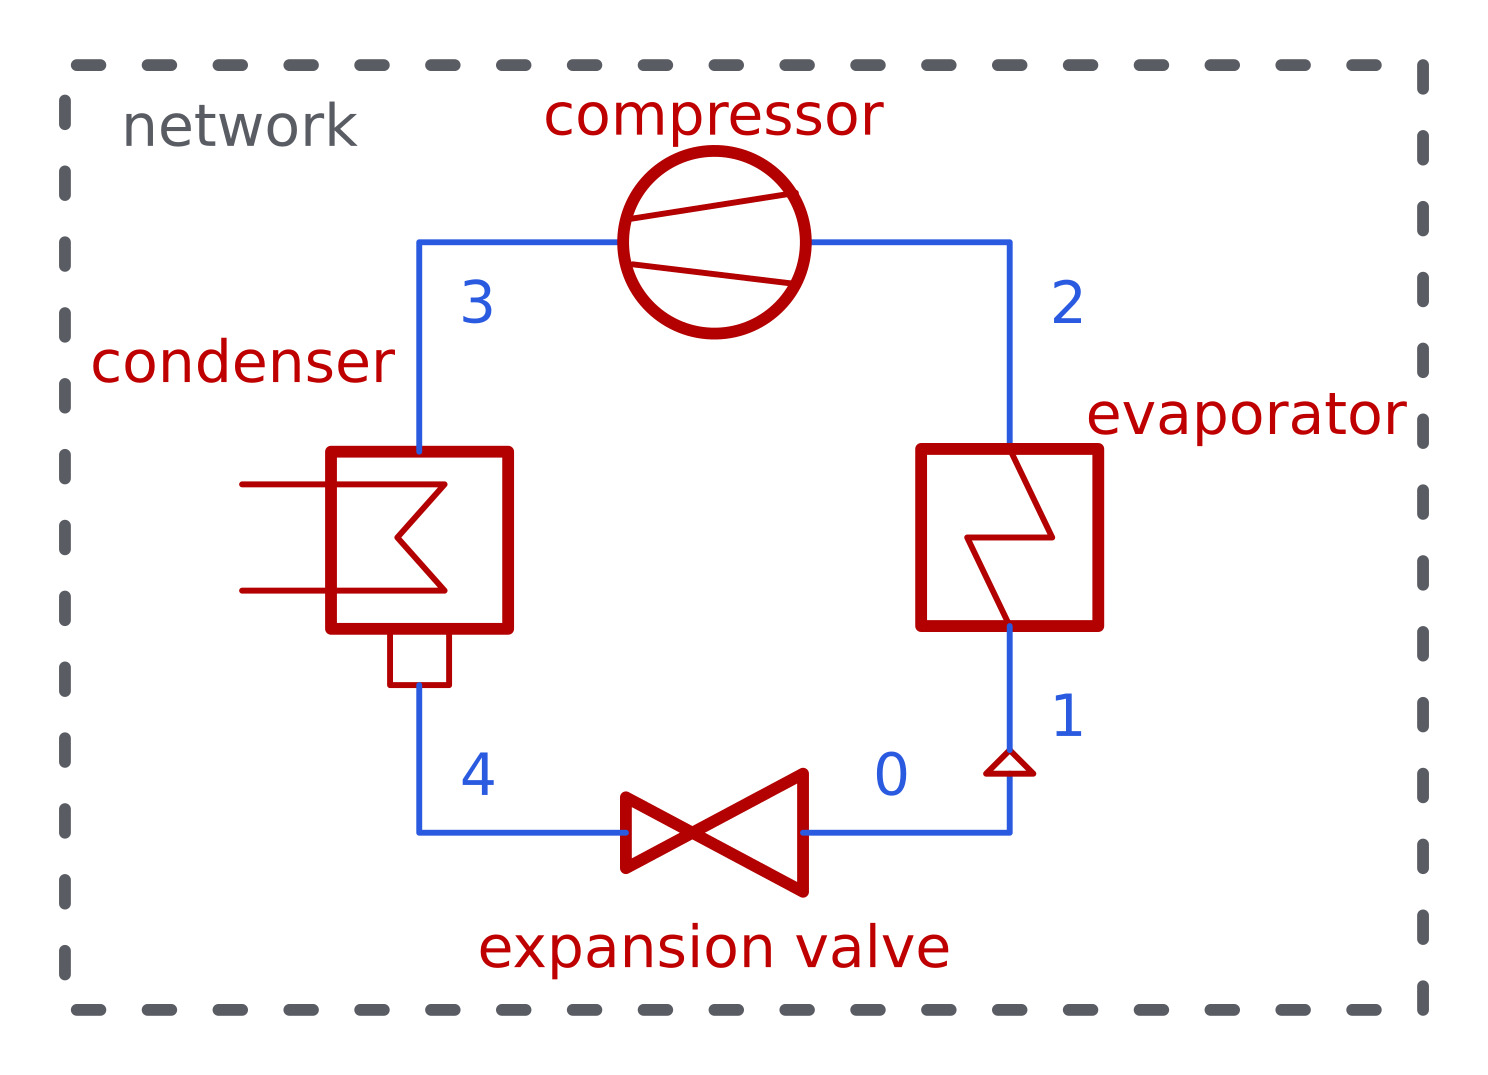


## **PID Controller** 


### The pid controller controles the mass flow rate of the compressor 

In [3]:
T_ambient = 35
T_cabin = 30
T_set = 25
k_gain = 300
C_cabin = 10000
dt = 1
steps = 2500


In [4]:
# used for looging data 
T_log, Qe_log, Pc_log, m_log = [], [], [], []

#  smoother PID functioning 
initial_adjustment_rate = 0.02  
max_correction = 0.05  
min_correction = 0.005 

previous_error = 0  # Previous error for derivative term
k_d = 0.01  # Derivative gain (tune this to control oscillations)



## **Hvac Simulation Loop**

In [13]:
%%captur
for t in range(steps):
    Q_gain = k_gain * (T_ambient - T_cabin)
    error = T_cabin - T_set
    m_old = c1.m.val
    
    # Derivative component for PD control
    derivative_error = error - previous_error
    previous_error = error
    
    # Proportional-Derivative control: smoothing out the error
    m_new = m_old + initial_adjustment_rate * error + k_d * derivative_error
    
    # Apply damping factor to reduce fluctuations
    correction_factor = min(1, t / 2000)  # Slowly increase correction factor
    m_new *= correction_factor
    
    m_new = max(min_correction, min(max_correction, m_new))
    
    c1.set_attr(m=m_new)
    hvac.solve('offdesign', design_path='hvac_design')
    
    Q_evap = evap.Q.val
    P_comp = comp.P.val
    net_Q = Q_gain - Q_evap
    T_cabin += (net_Q * dt) / C_cabin

    T_log.append(T_cabin)
    Qe_log.append(Q_evap)
    Pc_log.append(P_comp)
    m_log.append(m_new)




UsageError: Cell magic `%%captur` not found.


## **Battery pack modelling using Pybamm** 

In [6]:
def simulate_battery(current_load, simulation_time, initial_soc=0.8):
    model = pybamm.lithium_ion.DFN({"thermal": "lumped"})
    params = pybamm.ParameterValues(pybamm.parameter_sets["Chen2020"])
    params.update({
        "Nominal cell capacity [A.h]": 100,
        "Number of cells connected in series to make a battery": 14,
    })

    solver = pybamm.CasadiSolver()
    sim = pybamm.Simulation(model, parameter_values=params, solver=solver)
    solution = sim.solve([0, simulation_time], inputs={"Current function [A]": current_load})

    time = solution["Time [s]"].entries
    voltage = solution["Terminal voltage [V]"].entries
    ocv = solution["Battery open-circuit voltage [V]"].entries

    # SoC calculation via Coulomb counting
    Q_nominal = 100  # Ah
    dt_arr = np.diff(time, prepend=0)
    current_values = current_load(np.linspace(0, simulation_time, len(time)))
    soc = initial_soc - np.cumsum(current_values * dt_arr) / (3600 * Q_nominal)
    voltage_drop = voltage[0] - voltage

    return time, soc, voltage_drop, ocv


In [7]:
# The intial soc is set to 80 percent 

## **Results visualization**

In [8]:
def plot_simulation_results(time, soc, voltage_drop, ocv, T_log, Pc_log, T_set):
    steps = len(T_log)

    # Plot 3: Cabin Temp
    plt.figure(figsize=(10, 4))
    plt.plot(range(steps), T_log, label="Cabin Temp [°C]", color="tab:blue")
    plt.axhline(y=T_set, linestyle='--', color='red', label='Setpoint [°C]')
    plt.xlabel("Time [s]")
    plt.ylabel("Cabin Temperature")
    plt.title("Cabin Temperature Regulation")
    plt.grid(True)
    plt.legend()

    # Plot 4: Compressor Power
    plt.figure(figsize=(10, 4))
    plt.plot(range(steps), Pc_log, label="Compressor Power [W]", color="tab:orange")
    plt.xlabel("Time [s]")
    plt.ylabel("Power [W]")
    plt.title("Compressor Power Consumption")
    plt.grid(True)
    plt.legend()

    # Plot 5: OCV vs SoC
    plt.figure(figsize=(10, 4))
    plt.plot(soc, ocv, label="OCV vs SoC", color="purple")
    plt.xlabel("SoC")
    plt.ylabel("Open-Circuit Voltage [V]")
    plt.title("OCV vs SoC Curve")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


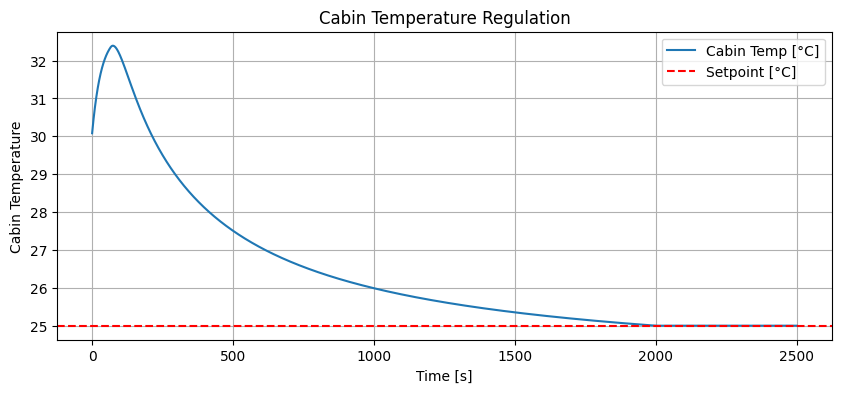

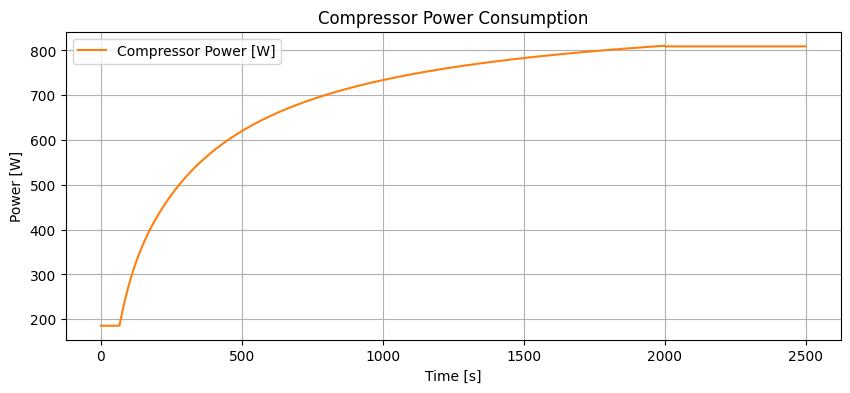

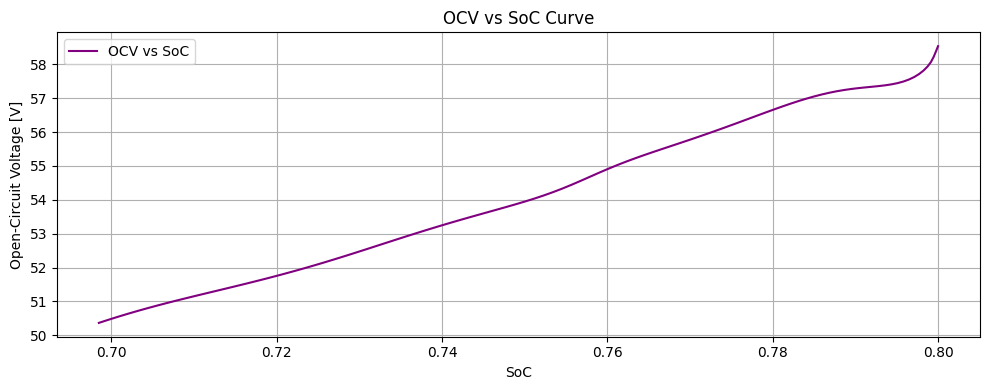

In [9]:
simulation_time = steps  
current_load = lambda t: np.interp(t, np.linspace(0, simulation_time, len(Pc_log)), Pc_log) / 48
time, soc, voltage_drop, ocv = simulate_battery(current_load, simulation_time)
plot_simulation_results(time, soc, voltage_drop, ocv, T_log, Pc_log, T_set)


# **Conclusions** 

##### 1) This simulation integrates TESPy for HVAC system modeling and PyBaMM for battery performance analysis. It tracks cabin temperature control and its effect on battery SoC and voltage drop over time. The results highlight a 10% SoC reduction and a 8 V voltage drop. This approach offers a detailed and efficient way to analyze HVAC impacts on EV battery performance.

##### 2) The model successfully maintains the cabin temperature at 25°C by dynamically adjusting compressor mass flow rate . However, slight underestimation of current or internal losses (including thermal and electrical losses) could lead to a 10% SoC drop. The thermal model ("lumped") also accounts for internal resistance heating, which increases energy consumption, further contributing to the observed SoC drop.(Which is completely a internal function of pybamm)

# **Key Takeaways**

## 1) Open-Source Frameworks for Cost Saving:

  ##### The use of open-source frameworks significantly reduces the reliance on proprietary software such as GT ISE, GT POST, and Simscape. This cost-effective approach allows for extensive simulation without the need for expensive licenses, making it ideal for research and development teams operating on a budget.

## 2) Simulation Time Efficiency:

  ##### The simulation time is relatively quicker compared to traditional tools, and the duration primarily depends on the complexity of the HVAC and battery models used. While simpler models may yield faster results, more intricate systems with numerous components may require additional computation time.

## 3) Enhanced Parameter Tracking and Insight:

  ##### One of the key advantages of integrating PyBaMM and TESPy is the ability to monitor and visualize a wide range of performance metrics—such as State of Charge (SoC), Open Circuit Voltage (OCV), compressor power, cabin temperature, and many other parameters documented within each library. This comprehensive visibility enables deeper system-level insight, informed optimization, and more effective decision-making during early-stage design and analysis.


## 4) Complex HVAC Models with TESPy:

  ##### TESPy offers the capability to build complex HVAC models, as it provides all necessary thermodynamic components. Additionally, TESPy includes engine thermodynamics, making it suitable not only for electric vehicles but also for internal combustion engine (ICE) vehicles. This versatility enhances the framework's applicability across a wide range of automotive system simulations.

## 5) PID Tuning for Refrigerant Massflow rate Control:

  ##### Proper tuning of the PID controller is essential for maintaining desired mass flow rate of the refrigerant . It is important to adjust the PID parameters based on the specific temperature setpoints required for the system, ensuring optimal performance and response times.

## 6) Integration of Standalone Models:

  ##### Both libraries, TESPy and PyBaMM, function as standalone models. It is the responsibility of the user to integrate these models through a loop, ensuring that the loop is properly managed. Careful attention is required while implementing the loop, as TESPy’s highly parametric-sensitive nature can lead to under- or over-constraining issues if not handled correctly.

## 7) Comparing Battery Models Across Platforms:

  ##### In PyBaMM, the resistance curve may not exactly align with that of comparative models found in GT Suite or Simscape. This discrepancy can arise due to differences in solver algorithms between GT and PyBaMM. Therefore, directly comparing battery models from different platforms, such as PyBaMM and other commercial tools, is often ineffective, as the underlying simulation methodologies and assumptions vary significantly.
